<a id="0"></a>

---
# PROBLEM STATEMENT
---

ContractNLI is a dataset for document-level natural language inference (NLI) on contracts whose goal is to automate/support a time-consuming procedure of contract review. In this task, a system is given a set of hypotheses (such as "Some obligations of Agreement may survive termination.") and a contract, and it is asked to classify whether each hypothesis is entailed by, contradicting to or not mentioned by (neutral to) the contract

![img](https://stanfordnlp.github.io/contract-nli/resources/task_overview.png)
## Dataset specification
We have 17 hypotheses annotated on 607 non-disclosure agreements (NDAs). The hypotheses are fixed throughout all the contracts including the test dataset.

- The task is Natural language inference (NLI): Document-level three-class classification (one of Entailment, Contradiction or NotMentioned).

**The core information in our dataset is:**

- `text`: The full document text
- `spans`: List of spans as pairs of the start and end character indices.
- `annotation_sets`: It is provided as a list to accommodate multiple annotations per document.
- `annotations`: Each key represents a hypothesis key. choice is either Entailment, Contradiction or NotMentioned. **`spans`** is given as indices of spans above. spans is empty when choice is NotMentioned.
- `labels`: Each key represents a hypothesis key. hypothesis is the hypothesis text that should be used in NLI.

---
# SETUP
---

**Installing the Hugging Face Library**


In [45]:
!pip install transformers
!pip install accelerate -U
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 6.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.20.3
    Uninstalling accelerate-0.20.3:
      Successfully uninstalled accelerate-0.20.3


In [46]:
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 50.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.30.2
    Uninstalling transformers-4.30.2:
      Successfully uninstalled transformers-4.30.2


In [47]:
pip install --upgrade torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 59.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 80.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 5.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 20.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 12.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 3.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 6.0 MB/s eta 0:00:0000:0100:01
     ━━━━

In [48]:
!pip install wordcloud
!pip install mplfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 2.9 MB/s eta 0:00:00


<a id="1.2"></a>
## Import Libraries

In [52]:
import re
import json
import numpy as np 

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

from tqdm.notebook import tqdm

In [53]:
import warnings
warnings.filterwarnings("ignore", message="Was asked to gather along dimension 0, but all input tensors were scalars")

In [54]:
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.precision = 0
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_colwidth', 50)

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance  as mpf

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pastel_colors = sns.color_palette("pastel", 10)

# Create the matplotlib finance figure with the specified style
style = mpf.make_mpf_style(base_mpf_style='charles', rc={'font.size': 10})
fig = mpf.figure(figsize=(18, 5), style=style)

pastel_colors

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

<Mpf_Figure size 1800x500 with 0 Axes>

<a id="1.3"></a>
## Using GPU

In [55]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
Device name: Tesla T4


## Load Datasets

In [56]:
def Json_parser(path):

    with open(path, 'r') as f:
        train_json = json.load(f)

    df = pd.DataFrame(columns = ['text', 'hypothesis', 'label', 'evidence_spans'])
    tmp = pd.DataFrame(columns = ['text', 'hypothesis', 'label', 'evidence_spans'])
    for doc in train_json['documents']:

        for ann in doc['annotation_sets']:

            labels = [label['choice'] for label in ann['annotations'].values()]
            evidence_spans = [label['spans'] for label in ann['annotations'].values()]
            hypotheses = [train_json['labels'][hyp]['hypothesis'] for hyp in ann['annotations'].keys()]

        tmp['hypothesis'] = hypotheses
        tmp['label']  = labels
        tmp['evidence_spans']  = evidence_spans
        tmp['text'] = [doc['text']]*len(labels)
        df = pd.concat([df,tmp],axis=0)

    return df

In [57]:
train_df = Json_parser('/kaggle/input/nplcontractnli/train.json')
val_df = Json_parser('/kaggle/input/nplcontractnli/dev.json')
test_df = Json_parser('/kaggle/input/nplcontractnli/test.json')

# Print shapes of dataframes
print(f"Train dataframe shape: {train_df.shape}")
print(f"Valid dataframe shape: {val_df.shape}")
print(f"Test dataframe shape: {test_df.shape}")

Train dataframe shape: (7191, 4)
Valid dataframe shape: (1037, 4)
Test dataframe shape: (2091, 4)


## Preparing Datasets

Using my defined function (`Json_parser`), the json files converted into a pandas DataFrame. The function processes the JSON data and extracts the required fields, such as 'text', 'hypothesis', 'label', and 'evidence_spans', from each document and annotation set, creating a new row in the DataFrame for each hypothesis annotation.

**The provided function takes the path of the JSON file as input and follows the following steps to create the DataFrame:**

1. Open the JSON file using json.load(f) to load its contents into the train_json variable.

2. The function iterates over the 'documents' in the JSON file (train_json['documents']). For each document, it proceeds to iterate over the 'annotation_sets' within that document.

3. Within the inner loop, the function extracts the following information for each hypothesis in the 'annotations':

- **labels**: The 'choice' field, representing the class ('Entailment', 'Contradiction', or 'NotMentioned').
- **evidence_spans**: The 'spans' field, representing the start and end character indices of relevant spans in the text.
- **hypotheses**: The hypothesis text associated with the current annotation.


4. Finally, the function returns the complete DataFrame df containing all the data from the JSON file, properly structured into the columns 'text', 'hypothesis', 'label', and 'evidence_spans'.



---
# EDA
---

### <font color = 'green'>What are the distributions of labels in train, test, and validation?

In [ ]:
# Let's visualize the sentiments
def Check_balance(df, col='label', title='Distribution of Labels on training set'):
    
    
    labels_counts = df.groupby([col]).size().sort_values(ascending = False)
    labels_counts = labels_counts.to_frame(name='count')
    labels_counts['proportion'] = labels_counts.apply(lambda x: (x['count']/labels_counts['count'].sum())*100, axis=1)
        
    fig, axs = plt.subplots(1,2, figsize=(12,4))
    axs[0].pie(labels_counts['count'], labels=labels_counts.index,
           colors=pastel_colors, autopct='%1.2f%%', pctdistance=1.2,
           labeldistance=1.5, textprops={'fontsize': 9})
    sns.barplot(x = labels_counts.index, y = labels_counts['count'], ax=axs[1],palette=pastel_colors)
    axs[1].set_xlabel('', fontsize=12, rotation= 60)
    axs[1].set_ylabel('', fontsize=12)
    fig.suptitle(title, fontsize=14)
  
    plt.tight_layout()#, pad=3)
    plt.show()
    
    return labels_counts

In [ ]:
def Distribution(df, col='hypothesis', title='Distribution of Hypothesis on Training set'):
    pastel_colors = sns.color_palette('pastel')

    labels_counts = df.groupby([col, 'label']).size().unstack(fill_value=0)
    print(labels_counts.shape)
    plt.figure(figsize=(5, 10))
    labels_counts.plot(kind='barh', stacked=True, color=pastel_colors, edgecolor='white', width=0.8)

    plt.ylabel(col, fontsize=12)
    plt.xlabel('Count', fontsize=12)
    plt.title(title, fontsize=14)

    plt.tight_layout()
    plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

    return labels_counts

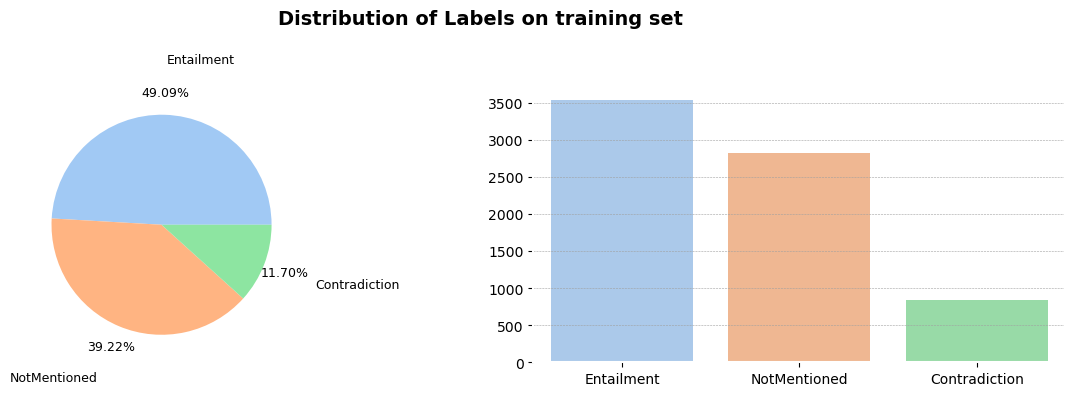

In [ ]:
train_res = Check_balance(train_df,'label', title='Distribution of Labels on training set')

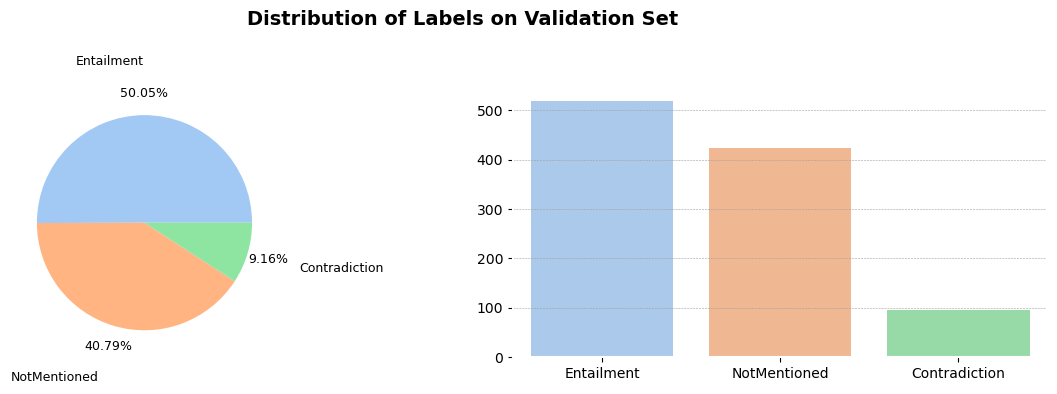

In [ ]:
val_res = Check_balance(val_df,'label' ,title='Distribution of Labels on Validation Set')

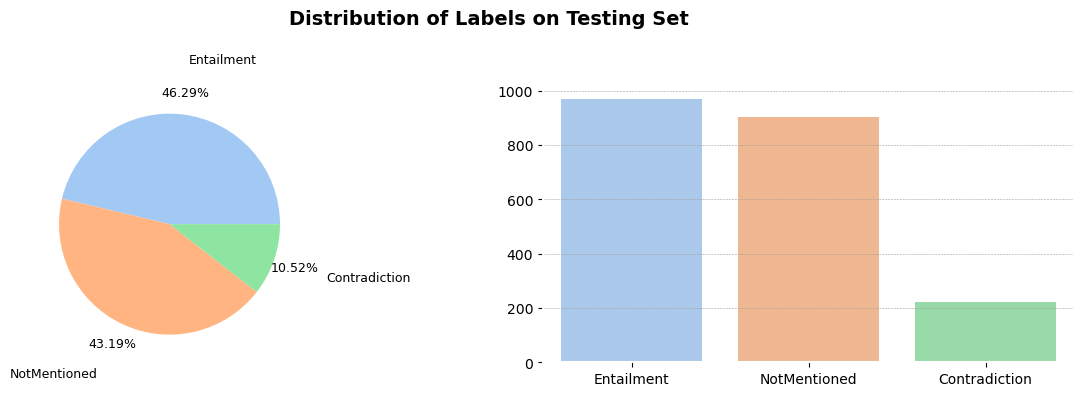

In [ ]:
test_res = Check_balance(test_df,'label' ,title='Distribution of Labels on Testing Set')

In [ ]:
train_res
val_res
test_res

count  proportion
label                           
Entailment      3530     49.0891
NotMentioned    2820     39.2157
Contradiction    841     11.6952

count  proportion
label                           
Entailment       519     50.0482
NotMentioned     423     40.7907
Contradiction     95      9.1610

count  proportion
label                           
Entailment       968     46.2936
NotMentioned     903     43.1851
Contradiction    220     10.5213

<a ><font size="3"><b>OBSERVATION:</b></font></a>
The `Entailment` label is the most frequent label in all three dataframes by almost 50% of the datasets, followed by the `NotMentioned` label by 40% and the `Contradiction` label by 10%. But no `Entailmen` label in testset.


### <font color = 'green'> Hypothisis Distribution

    
| Title                              | Hypothesis                                                                                 |
|---------------------------------------------|---------------------------------------------------------------------------------------------|
| Explicit identification                    | All Confidential Information shall be expressly identified by the Disclosing Party.        |
| Non-inclusion of non-technical information | Confidential Information shall only include technical information.                         |
| Inclusion of verbally conveyed information | Confidential Information may include verbally conveyed information.                        |
| Limited use                                 | Receiving Party shall not use any Confidential Information for any purpose other than the purposes stated in Agreement. |
| Sharing with employees                     | Receiving Party may share some Confidential Information with some of Receiving Party’s employees. |
| Sharing with third-parties                 | Receiving Party may share some Confidential Information with some third-parties (including consultants, agents, and professional advisors). |
| Notice on compelled disclosure             | Receiving Party shall notify the Disclosing Party if Receiving Party is required by law, regulation, or judicial process to disclose any Confidential Information. |
| Confidentiality of Agreement               | Receiving Party shall not disclose the fact that the Agreement was agreed or negotiated.      |
| No reverse engineering                     | Receiving Party shall not reverse engineer any objects that embody Disclosing Party’s Confidential Information. |
| Permissible development of similar information | Receiving Party may independently develop information similar to Confidential In-         |
| Permissible acquisition of similar information | Receiving Party may acquire information similar to Confidential Information from a party. |
| No licensing Agreement shall not grant     | Receiving Party any right to Confidential Information.                                      |
| Return of confidential information         | The Receiving Party shall destroy or return some Confidential Information upon the termination of the Agreement. |
| Permissible copy                           | Receiving Party may create a copy of some Confidential Information in some circumstances.   |
| No solicitation                            | The Receiving Party shall not solicit some of the Disclosing Party’s representatives.      |
| Survival of obligations                    | Some obligations of the Agreement may survive the termination of the Agreement.             |
| Permissible post-agreement possession      | Receiving Party may retain some Confidential Information even after the return or destruction of Confidential Information. |

***Dictionary with the mappings of Hypothesis to Title**


In [ ]:
mapping = {
    "Receiving Party shall not reverse engineer any objects which embody Disclosing Party's Confidential Information.": "No reverse engineering",
    "Receiving Party shall destroy or return some Confidential Information upon the termination of Agreement.": "Return of confidential information",
    "Agreement shall not grant Receiving Party any right to Confidential Information.": "No licensing Agreement shall not grant",
    "Receiving Party shall not disclose the fact that Agreement was agreed or negotiated.": "Confidentiality of Agreement",
    "Confidential Information shall only include technical information.": "Non-inclusion of non-technical information",
    "All Confidential Information shall be expressly identified by the Disclosing Party.": "Explicit identification",
    "Some obligations of Agreement may survive termination of Agreement.": "Survival of obligations",
    "Receiving Party may independently develop information similar to Confidential Information.": "Permissible development of similar information",
    "Receiving Party may retain some Confidential Information even after the return or destruction of Confidential Information.": "Permissible post-agreement possession",
    "Confidential Information may include verbally conveyed information.": "Inclusion of verbally conveyed information",
    "Receiving Party shall not solicit some of Disclosing Party's representatives.": "No solicitation",
    "Receiving Party may share some Confidential Information with some third-parties (including consultants, agents and professional advisors).": "Sharing with third-parties",
    "Receiving Party may create a copy of some Confidential Information in some circumstances.": "Permissible copy",
    "Receiving Party shall notify Disclosing Party in case Receiving Party is required by law, regulation or judicial process to disclose any Confidential Information.": "Notice on compelled disclosure",
    "Receiving Party may acquire information similar to Confidential Information from a third party.": "Permissible acquisition of similar information",
    "Receiving Party may share some Confidential Information with some of Receiving Party's employees.": "Sharing with employees",
    "Receiving Party shall not use any Confidential Information for any purpose other than the purposes stated in Agreement.": "Limited use"
}


# Use the map function to create the "Title" column based on the "Hypothesis" column
train_df['hypothesis_title'] = train_df['hypothesis'].map(mapping)

 documents exceed the maximum allowed context length of BERT

### <font color = 'green'>Distribution of NLI labels in the dataset per Hypothesis.


(17, 3)


<Figure size 500x1000 with 0 Axes>

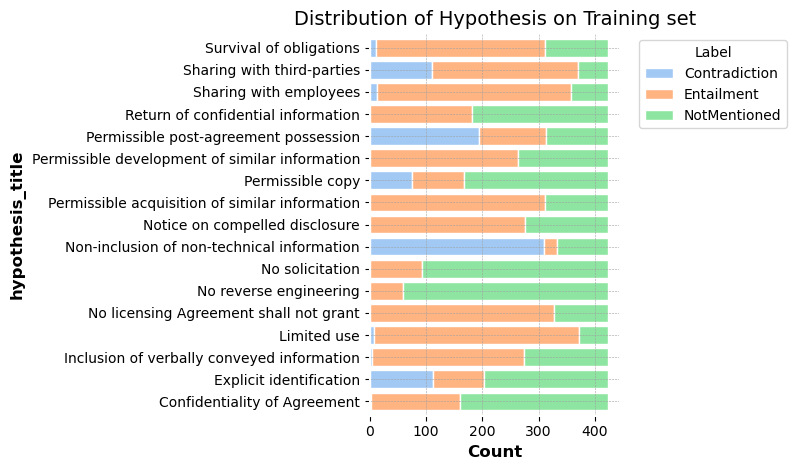

In [ ]:
train_res = Distribution(train_df, col = 'hypothesis_title')

### <font color = 'green'>Analyze the words per each document in the train, test, validation.


In [ ]:
def count_words(text):
    return len(text.split())

In [ ]:
train_df['num_words'] = train_df['text'].apply(count_words)
test_df['num_words'] = test_df['text'].apply(count_words)
val_df['num_words'] = val_df['text'].apply(count_words)

# Calculate mean words per document by class
print(' >>>>>>>> Mean number of words for each label <<<<<< '.upper())
print('----------------- Training Dataset -----------------')
print(train_df.groupby('label').num_words.mean().rename('Mean number of words for each label'))     
print('\n----------------- Validation Dataset -----------------')
print(val_df.groupby('label').num_words.mean().rename('Mean number of words for each label')) 
print('\n----------------- Testing Dataset -----------------')
print(test_df.groupby('label').num_words.mean().rename('Mean number of words for each label')) 


print('\n >>>>>> The mean words per document in each dataset <<<<<< \n')
print(f"\tTraining set:\t {train_df['num_words'].mean():.2f}")
print(f"\tTest set:\t {test_df['num_words'].mean():.2f}")
print(f"\tValidation set:\t {val_df['num_words'].mean():.2f}")

 >>>>>>>> MEAN NUMBER OF WORDS FOR EACH LABEL <<<<<< 
----------------- Training Dataset -----------------
label
Contradiction   1,622.2152
Entailment      1,869.1102
NotMentioned    1,444.2695
Name: Mean number of words for each label, dtype: float64

----------------- Validation Dataset -----------------
label
Contradiction   1,878.4000
Entailment      1,983.6069
NotMentioned    1,615.5508
Name: Mean number of words for each label, dtype: float64

----------------- Testing Dataset -----------------
label
Contradiction   1,696.5455
Entailment      1,864.2676
NotMentioned    1,545.1761
Name: Mean number of words for each label, dtype: float64

 >>>>>> The mean words per document in each dataset <<<<<< 

	Training set:	 1673.63
	Test set:	 1708.82
	Validation set:	 1823.84


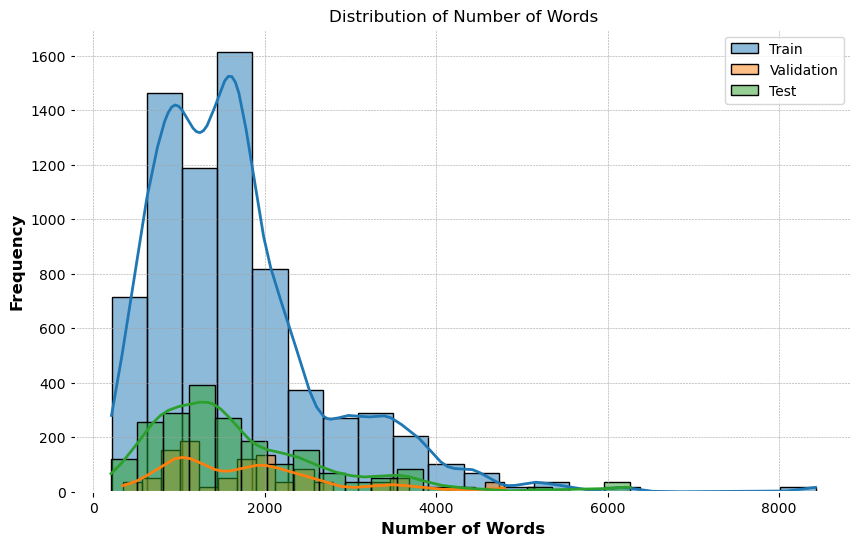

In [ ]:
from seaborn.palettes import color_palette
InteractiveShell.ast_node_interactivity = "last_expr"

plt.figure(figsize=(10, 6))
datasets = [train_df, val_df, test_df]

for dataset, label in zip(datasets, ['Train', 'Validation', 'Test']):
    sns.histplot(dataset['num_words'], bins=20, kde=True, label=label)

plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Words')
plt.legend(loc='upper right')
plt.show()

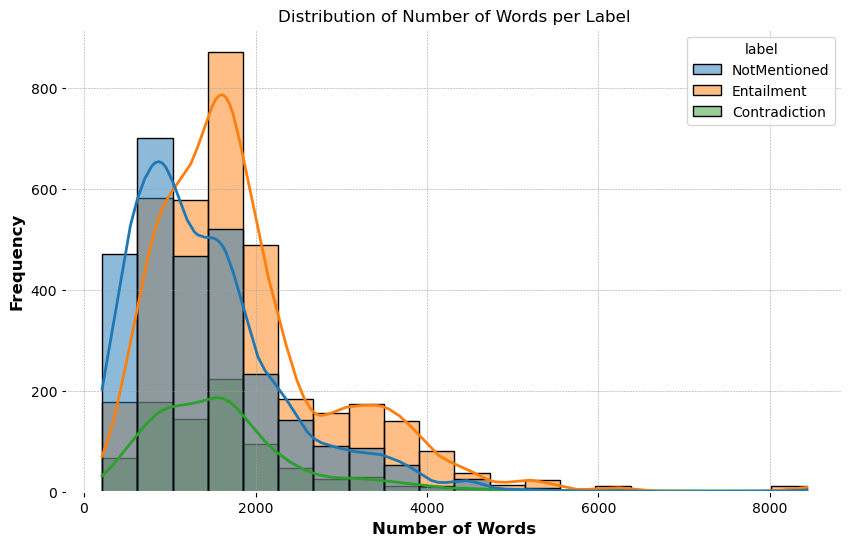

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=train_df, x='num_words', bins=20, kde=True, hue='label', color='label')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Words per Label')
plt.show()

<a ><font size="3"><b>OBSERVATION:</b></font></a>
- These results suggest that the documents in the dataset are too long, with an average length of around 1800 words per document.
- The 'Entailment' label tends to have the highest mean number of words per document, followed by the 'NotMentioned' label and the 'Contradiction' label.
- The variation in mean words per document between the labels is relevant. This information can be useful in selecting appropriate text processing methods, such as setting the maximum sequence length
- An average number of tokens per document is 1,673.0, which is larger than the maximum allowed context length of BERT (512 tokens).
- 94.80% of the training documents exceed the maximum allowed context length of BERT.

### <font color = 'green'> Percentage of documents exceed the maximum allowed context length of BERT (512 token).
    
How many rows in each DataFrame have 'num_words' greater than 512, 


In [ ]:
train_proportion = sum(train_df['num_words'] > 512) / len(train_df)
val_proportion = sum(val_df['num_words'] > 512) / len(val_df)
test_proportion = sum(test_df['num_words'] > 512) / len(test_df)

print(f"Proportion of rows with 'num_words' > 512 in train_df:\t{train_proportion *100 :0.2f}%")
print(f"Proportion of rows with 'num_words' > 512 in val_df  :\t{val_proportion *100 :0.2f}%")
print(f"Proportion of rows with 'num_words' > 512 in test_df :\t{test_proportion *100 :0.2f}%")

Proportion of rows with 'num_words' > 512 in train_df:	94.80%
Proportion of rows with 'num_words' > 512 in val_df  :	96.72%
Proportion of rows with 'num_words' > 512 in test_df :	94.31%


In [ ]:
from wordcloud import WordCloud, STOPWORDS
stop_words =list(STOPWORDS)

def CloudWords(df):
    
    fig, axs = plt.subplots(1,3, figsize=(15,15))
    fig.subplots_adjust(wspace=0.05, hspace=0.05)
    for i, label in enumerate(df.label.unique()):

        Texts = df[df["label"] == label]['text']
        text = ' '.join(Texts)
        
        wordcloud = WordCloud(width=800, height=800, background_color='black', stopwords=STOPWORDS, max_font_size=150).generate(text)
        axs[i].imshow(wordcloud, interpolation="bilinear")
        axs[i].set_title(f"{label}".title(), fontsize = 14)
        axs[i].axis("off")
        
    plt.show()

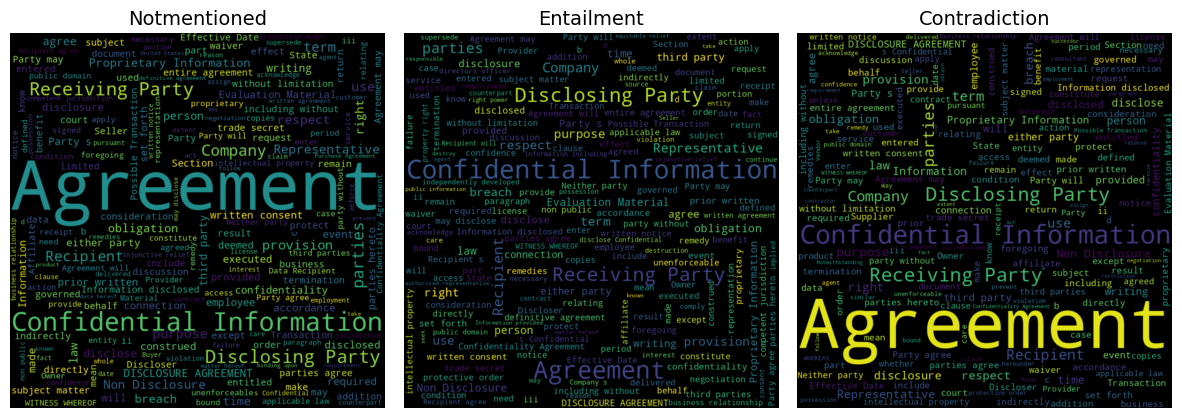

In [ ]:
CloudWords(train_df)

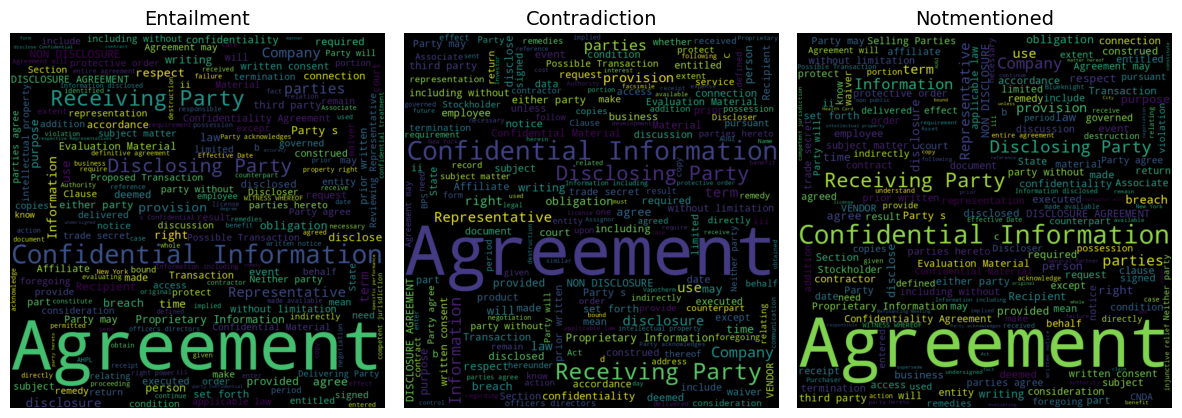

In [ ]:
CloudWords(val_df)

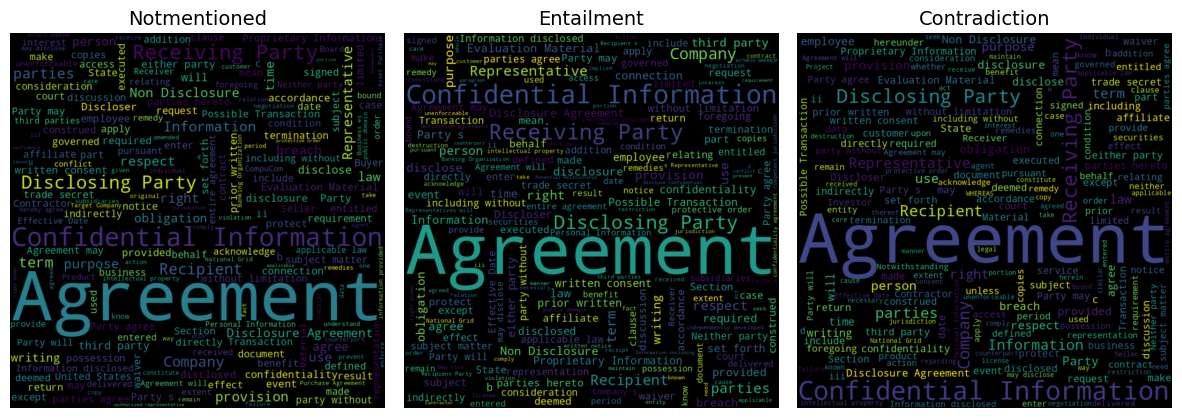

In [ ]:
CloudWords(test_df)

<a id="3"></a>

---
# TEXT PREPROCESSING
---

In [58]:
def text_preprocessing(s):
    """
    Preprocesses input text by performing the following steps:
    - Lowercases the text.
    - Replaces contractions of "not" with the full word.
    - Removes quotes around text enclosed in double quotes.
    - Removes parentheses and their contents.
    - Removes special characters like `;`, `:`, `|`, `•`, `«`, newline (`\n`), `@`, `#`, `%`, `$`, `^`, `*`, `~`, `_`, `-`.
    - Removes single characters that are surrounded by whitespace.
    - Removes any numbers.
    - Replaces multiple consecutive dots with a single dot.
    - Replaces any space character that appears before a dot with just a dot.
    - Removes any extra whitespace.
    - Removes trailing whitespace.
    """

    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove quotes around text enclosed in double quotes
    s = re.sub(r'“(.*?)”', r'\1', s)
    # Remove parentheses and their contents
    s = re.sub(r'\([^)]*\)', '', s)
    # Remove either "(i)" or "(ii)" to indicate the party number, as well as forward slashes
    s = re.sub(r'(\(i\)|\(ii\)|\/+)', '', s)
    # Remove some special characters
    # ;, :, |, •, «, newline (\n), @, #, %, $, ^, *, ~, _, -.
    s = re.sub(r'([\;\:\|•«\n@#%$^*~_-])', ' ', s)
    # Remove single characters
    s = re.sub(r'\s+[a-zA-Z]\s+', '', s)
    # Remove numbers
    s = re.sub(r'\d+', '', s)
    # Replace multiple consecutive dots with a single dot
    s = re.sub(r'\.{1,}', '.', s)
    # Replace any space character that appears before a dot with just a dot
    s = re.sub(r'\s\.', '.', s)
    # Remove any extra whitespace
    s = re.sub(r'\s+', ' ', s)
    # Remove trailing whitespace
    s = re.sub(r'\s+$', '', s)
    return s

In [59]:
%%time
train_df['processed_text'] = train_df['text'].apply(text_preprocessing)
val_df['processed_text'] = val_df['text'].apply(text_preprocessing)
test_df['processed_text'] = test_df['text'].apply(text_preprocessing)

CPU times: user 44.1 s, sys: 127 ms, total: 44.3 s
Wall time: 44.4 s


### Encoding


In [60]:
%%time
mapping = {'Entailment':2,'NotMentioned':1,'Contradiction':0}
train_df['label'] = train_df['label'].map(mapping)
val_df['label'] = val_df['label'].map(mapping)
test_df['label'] = test_df['label'].map(mapping)

CPU times: user 5.54 ms, sys: 0 ns, total: 5.54 ms
Wall time: 6.77 ms


---
# MODEL1: DeBERTa-base with processed text
---

## Define the DeBERTa model and tokenizer

In [61]:
# Load the DeBERTa tokenizer and model
model_name = 'microsoft/deberta-base'
tokenizer1 = AutoTokenizer.from_pretrained(model_name)
model1 = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.weight', 'pooler.dense.bias', 'classifier.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Create DataLoader
### Define a custom dataset for NLI Contact

In [62]:
class NliDataset(Dataset):
    
    def __init__(self, texts, hypotheses, labels , tokenizer=tokenizer1, max_length=512):
        self.texts = texts
        self.hypotheses = hypotheses
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.labels = labels

    def __len__(self):
        return len(self.hypotheses)

    def __getitem__(self, idx):
        
        text = self.texts[idx]
        hypothesis = self.hypotheses[idx]
        encoding = self.tokenizer(text=text,
                                  text_pair=hypothesis,
                                  truncation=True,
                                  padding="max_length",
                                  max_length=self.max_length,
                                  return_attention_mask=True,
                                  return_token_type_ids=True,
                                  return_tensors='pt')
        
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        token_type_ids = encoding['token_type_ids'].squeeze()
        
        label = torch.tensor(int(self.labels[idx]))
        encoding['labels'] = label
        
        return {
            'input_ids': input_ids,
            'hypothesis': hypothesis,
            'attention_mask': attention_mask,
            'token_type_ids': token_type_ids,
            'labels': label,
        }

In [63]:
# Get the lists of sentences and their labels.
train_texts = train_df['processed_text'].tolist()
train_hypotheses = train_df['hypothesis'].tolist()
train_labels = train_df['label'].tolist()

val_texts = val_df['processed_text'].tolist()
val_hypotheses = val_df['hypothesis'].tolist()
val_labels = train_df['label'].tolist()

test_texts = test_df['processed_text'].tolist()
test_hypotheses = test_df['hypothesis'].tolist()
test_labels = train_df['label'].tolist()

In [64]:
# Create datasets
train_data = NliDataset(train_texts, train_hypotheses, train_labels, tokenizer1)
val_data = NliDataset(val_texts, val_hypotheses, val_labels,tokenizer1)
test_data = NliDataset(test_texts, test_hypotheses, test_labels,tokenizer1)

### Display a sample from the dataset

In [65]:
data_loader = DataLoader(train_data, batch_size=4, shuffle=True)
n=1
for i, batch in enumerate(data_loader):
    if i >= n:
        break
    decoded_text = tokenizer1.decode(batch['input_ids'][i], skip_special_tokens=True)

    print(f"Sample {i+1}:")
    print('-'*10)
    print("\n>>>> Input Text:\n", decoded_text)
    print("\n>>>> Hypothesis:\n", batch['hypothesis'][i])
    print("\n>>>> Inpue IDs:", batch['input_ids'][i])
    print("\n>>>> Label:", batch['labels'][i])
    print("="*100)

Sample 1:
----------

>>>> Input Text:
 exhibit non disclosure agreement this non disclosure agreement is made and entered into this st day of january,, by and between zebra technologies corporation,delaware corporation and xplore technologies corp.,delaware corporation. company and xplore sometimes are referred to herein asparty and collectively as the parties. whereas, each of company and xplore possesses certain non public, confidential andor proprietary information relating to its businesses that it proposes to disclose to the other party for the purpose of evaluatingpossible transaction between company and xplore now, therefore, in consideration of the mutual promises contained herein, company and xplore hereby agree as follows. each of company and xplore agrees to hold the other party’s information in confidence in accordance with the provisions hereof.. without the prior written consent of the other party or except as otherwise provided herein, neither company nor xplore will di

## Training DeBERTa using processed text

### Define Compute Metrics

In [66]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Calculate accuracy
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average=None, zero_division=1)
    macro_f1 = np.mean(f1)

    return {
        'Accuracy': accuracy,
        'Precision_Contradiction': precision[0],
        'Precision_NotMentioned': precision[1],
        'Precision_Entailment': precision[2],
        'Recall_Contradiction': recall[0],
        'Recall_NotMentioned': recall[1],
        'Recall_Entailment': recall[2],
        'F1_score_Contradiction': f1[0],
        'F1_score_NotMentioned': f1[1],
        'F1_score_Entailment': f1[2],
        'macro_f1_score': macro_f1,
    }

### Trainer Initialization


In [151]:
%cd /kaggle/working/

/kaggle/working


In [152]:
import torch.optim as optim

EPOCHS = 3
BATCH_SIZE = 8

# optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
)

In [153]:
trainer1 = Trainer(
    model=model1,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    tokenizer=tokenizer1,
    compute_metrics=compute_metrics,
#     optimizers=(optimizer, None),
)

In [154]:
TrainOutput1 = trainer1.train()
Train_metrics1 = pd.DataFrame([TrainOutput1.metrics])
Train_metrics1 

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


You're using a DebertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


train_runtime  train_samples_per_second  train_steps_per_second  \
0     2,317.1641                    9.3100                  0.5830   

                  total_flos  train_loss  epoch  
0 6,614,280,971,596,800.0000      0.6540 3.0000

In [155]:
torch.cuda.empty_cache()

## Evaluation

In [156]:
val_metrics1 = trainer1.evaluate(eval_dataset=val_data)
val_metrics1

{'eval_loss': 1.0921695232391357,
 'eval_Accuracy': 0.583413693346191,
 'eval_Precision_Contradiction': 0.5288461538461539,
 'eval_Precision_NotMentioned': 0.5304740406320542,
 'eval_Precision_Entailment': 0.6428571428571429,
 'eval_Recall_Contradiction': 0.39855072463768115,
 'eval_Recall_NotMentioned': 0.5703883495145631,
 'eval_Recall_Entailment': 0.6468172484599589,
 'eval_F1_score_Contradiction': 0.45454545454545453,
 'eval_F1_score_NotMentioned': 0.5497076023391813,
 'eval_F1_score_Entailment': 0.6448311156601843,
 'eval_macro_f1_score': 0.5496947241816067,
 'eval_runtime': 41.2195,
 'eval_samples_per_second': 25.158,
 'eval_steps_per_second': 1.577,
 'epoch': 3.0}

## Testing

In [157]:
test_predictions = trainer1.predict(test_data)
test_preds1 = np.argmax(test_predictions.predictions, axis=1)
test_metrics1 = trainer1.evaluate(eval_dataset=test_data)
test_metrics1

{'eval_loss': 1.0713762044906616,
 'eval_Accuracy': 0.6001912960306074,
 'eval_Precision_Contradiction': 0.4798206278026906,
 'eval_Precision_NotMentioned': 0.5452352231604343,
 'eval_Precision_Entailment': 0.6698748796920115,
 'eval_Recall_Contradiction': 0.4163424124513619,
 'eval_Recall_NotMentioned': 0.565,
 'eval_Recall_Entailment': 0.6731141199226306,
 'eval_F1_score_Contradiction': 0.44583333333333336,
 'eval_F1_score_NotMentioned': 0.5549416820135052,
 'eval_F1_score_Entailment': 0.6714905933429811,
 'eval_macro_f1_score': 0.5574218695632732,
 'eval_runtime': 82.1162,
 'eval_samples_per_second': 25.464,
 'eval_steps_per_second': 1.595,
 'epoch': 3.0}

In [158]:
from sklearn.metrics import classification_report

report = classification_report(test_df['label'], test_preds1)
print(report)

              precision    recall  f1-score   support

           0       0.54      0.55      0.55       220
           1       0.79      0.72      0.75       903
           2       0.77      0.83      0.80       968

    accuracy                           0.75      2091
   macro avg       0.70      0.70      0.70      2091
weighted avg       0.75      0.75      0.75      2091



In [159]:
InteractiveShell.ast_node_interactivity = "last_expr"

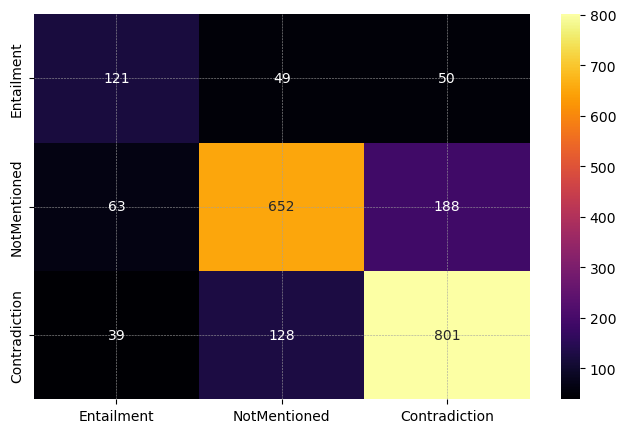

In [160]:
InteractiveShell.ast_node_interactivity = "last_expr"

class_labels = mapping.keys()

cm1 = confusion_matrix(test_df['label'], test_preds1)

plt.figure(figsize=(8, 5))
sns.heatmap(cm1, annot=True, fmt='d', cmap='inferno', xticklabels=class_labels, yticklabels=class_labels)

# Add labels, title, and axis ticks
plt.xticks(np.arange(len(class_labels)) + 0.5, class_labels)
plt.yticks(np.arange(len(class_labels)) + 0.5, class_labels)

# Display the heatmap
plt.show()

<a ><font size="3"><b>OBSERVATION:</b></font></a>

- The model seems to be performing reasonably well, especially on the validation set during training.
- It exhibits relatively balanced performance across classes, with no class dominating the others.

---
# MODEL2: DeBERTa-base with original text
---

## Define the model and tokenizer

In [15]:
model_name = 'microsoft/deberta-base'
tokenizer2 = AutoTokenizer.from_pretrained(model_name)
model2 = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.d

In [16]:
train_texts = train_df['text'].tolist()
val_texts = val_df['text'].tolist()
test_texts = test_df['text'].tolist()

In [18]:
train_data = NliDataset(train_texts, train_hypotheses, train_labels, tokenizer2)
val_data = NliDataset(val_texts, val_hypotheses, val_labels,tokenizer2)
test_data = NliDataset(test_texts, test_hypotheses, test_labels,tokenizer2)

## Training DeBERTa-base with original text

In [26]:
trainer2 = Trainer(
    model=model2,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    tokenizer=tokenizer2,
    compute_metrics=compute_metrics,
#     optimizers=(optimizer, None),
)

In [27]:
TrainOutput2 = trainer2.train()
TrainOutput2 = pd.DataFrame([TrainOutput2.metrics])
TrainOutput2

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


You're using a DebertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


train_runtime  train_samples_per_second  train_steps_per_second  \
0     2,314.6010                    9.3200                  0.5830   

                  total_flos  train_loss  epoch  
0 6,614,280,971,596,800.0000      0.6705 3.0000

## Evaluation

In [28]:
val_metrics2 = trainer2.evaluate(eval_dataset=val_data)
val_metrics2

{'eval_loss': 1.0135396718978882,
 'eval_Accuracy': 0.6036644165863067,
 'eval_Precision_Contradiction': 0.5664335664335665,
 'eval_Precision_NotMentioned': 0.5639686684073107,
 'eval_Precision_Entailment': 0.6438356164383562,
 'eval_Recall_Contradiction': 0.5869565217391305,
 'eval_Recall_NotMentioned': 0.5242718446601942,
 'eval_Recall_Entailment': 0.675564681724846,
 'eval_F1_score_Contradiction': 0.5765124555160143,
 'eval_F1_score_NotMentioned': 0.5433962264150944,
 'eval_F1_score_Entailment': 0.6593186372745492,
 'eval_macro_f1_score': 0.5930757730685526,
 'eval_runtime': 42.5861,
 'eval_samples_per_second': 24.351,
 'eval_steps_per_second': 1.526,
 'epoch': 3.0}

## Testing

In [29]:
test_predictions = trainer2.predict(test_data)
test_preds2 = np.argmax(test_predictions.predictions, axis=1)
test_metrics2 = trainer2.evaluate(eval_dataset=test_data)
test_metrics2

{'eval_loss': 0.9629577398300171,
 'eval_Accuracy': 0.6255380200860832,
 'eval_Precision_Contradiction': 0.5406360424028268,
 'eval_Precision_NotMentioned': 0.5809768637532133,
 'eval_Precision_Entailment': 0.6825242718446602,
 'eval_Recall_Contradiction': 0.5953307392996109,
 'eval_Recall_NotMentioned': 0.565,
 'eval_Recall_Entailment': 0.6798839458413927,
 'eval_F1_score_Contradiction': 0.5666666666666667,
 'eval_F1_score_NotMentioned': 0.5728770595690748,
 'eval_F1_score_Entailment': 0.6812015503875969,
 'eval_macro_f1_score': 0.6069150922077795,
 'eval_runtime': 84.2545,
 'eval_samples_per_second': 24.818,
 'eval_steps_per_second': 1.555,
 'epoch': 3.0}

In [30]:
from sklearn.metrics import classification_report

report = classification_report(test_df['label'], test_preds2, zero_division=1)
print(report)

              precision    recall  f1-score   support

           0       0.53      0.68      0.59       220
           1       0.77      0.66      0.71       903
           2       0.75      0.80      0.77       968

    accuracy                           0.73      2091
   macro avg       0.68      0.71      0.69      2091
weighted avg       0.73      0.73      0.73      2091



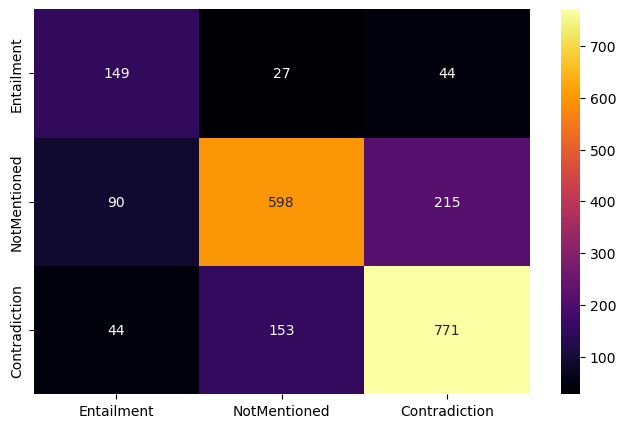

In [31]:
class_labels = mapping.keys()

cm2 = confusion_matrix(test_df['label'], test_preds2)

plt.figure(figsize=(8, 5))
sns.heatmap(cm2, annot=True, fmt='d', cmap='inferno', xticklabels=class_labels, yticklabels=class_labels)

# Add labels, title, and axis ticks
plt.xticks(np.arange(len(class_labels)) + 0.5, class_labels)
plt.yticks(np.arange(len(class_labels)) + 0.5, class_labels)

# Display the heatmap
plt.show()

<a ><font size="3"><b>OBSERVATION:</b></font></a>

- The model's performance on the testing set seems reasonable, with an accuracy of around 63%.
- The model exhibits balanced performance across classes, but there might be some difficulty in distinguishing between "Contradivtion" and "NotMentioned" classes as indicated by lower precision, recall, and F1 score for those classes compared to "Contradiction."

---
# MODEL3: RoBERTa-base with original text
---

## Define the model and tokenizer

In [32]:
model_name = 'roberta-base'

tokenizer3 = AutoTokenizer.from_pretrained(model_name)
model3 = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should pr

In [33]:
train_texts = train_df['text'].tolist()
val_texts = val_df['text'].tolist()
test_texts = test_df['text'].tolist()

In [34]:
train_data = NliDataset(train_texts, train_hypotheses, train_labels, tokenizer3)
val_data = NliDataset(val_texts, val_hypotheses, val_labels,tokenizer3)
test_data = NliDataset(test_texts, test_hypotheses, test_labels,tokenizer3)

## Training

In [36]:
trainer3 = Trainer(
    model=model3,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    tokenizer=tokenizer3,
    compute_metrics=compute_metrics,
#     optimizers=(optimizer, None),
)

In [37]:
TrainOutput3 = trainer3.train()
TrainOutput3 = pd.DataFrame([TrainOutput3.metrics])
TrainOutput3

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


train_runtime  train_samples_per_second  train_steps_per_second  \
0     1,532.8097                   14.0740                  0.8810   

                  total_flos  train_loss  epoch  
0 5,676,145,760,646,144.0000      0.7105 3.0000

## Evaluation

In [38]:
val_metrics3 = trainer3.evaluate(eval_dataset=val_data)
val_metrics3

{'eval_loss': 0.9278629422187805,
 'eval_Accuracy': 0.6171648987463838,
 'eval_Precision_Contradiction': 0.5703703703703704,
 'eval_Precision_NotMentioned': 0.584,
 'eval_Precision_Entailment': 0.6527514231499051,
 'eval_Recall_Contradiction': 0.5579710144927537,
 'eval_Recall_NotMentioned': 0.5315533980582524,
 'eval_Recall_Entailment': 0.7063655030800822,
 'eval_F1_score_Contradiction': 0.5641025641025642,
 'eval_F1_score_NotMentioned': 0.5565438373570522,
 'eval_F1_score_Entailment': 0.6785009861932939,
 'eval_macro_f1_score': 0.5997157958843035,
 'eval_runtime': 30.3173,
 'eval_samples_per_second': 34.205,
 'eval_steps_per_second': 2.144,
 'epoch': 3.0}

## Testing

In [39]:
test_predictions = trainer3.predict(test_data)
test_preds3 = np.argmax(test_predictions.predictions, axis=1)
test_metrics3 = trainer3.evaluate(eval_dataset=test_data)
test_metrics3

{'eval_loss': 0.8855632543563843,
 'eval_Accuracy': 0.632233381157341,
 'eval_Precision_Contradiction': 0.5503597122302158,
 'eval_Precision_NotMentioned': 0.5816582914572864,
 'eval_Precision_Entailment': 0.6941986234021632,
 'eval_Recall_Contradiction': 0.5953307392996109,
 'eval_Recall_NotMentioned': 0.57875,
 'eval_Recall_Entailment': 0.6827852998065764,
 'eval_F1_score_Contradiction': 0.57196261682243,
 'eval_F1_score_NotMentioned': 0.5802005012531328,
 'eval_F1_score_Entailment': 0.6884446611409069,
 'eval_macro_f1_score': 0.6135359264054899,
 'eval_runtime': 59.8739,
 'eval_samples_per_second': 34.923,
 'eval_steps_per_second': 2.188,
 'epoch': 3.0}

In [40]:
report = classification_report(test_df['label'], test_preds3)
print(report)

              precision    recall  f1-score   support

           0       0.50      0.63      0.55       220
           1       0.76      0.67      0.71       903
           2       0.76      0.79      0.77       968

    accuracy                           0.72      2091
   macro avg       0.67      0.70      0.68      2091
weighted avg       0.73      0.72      0.72      2091



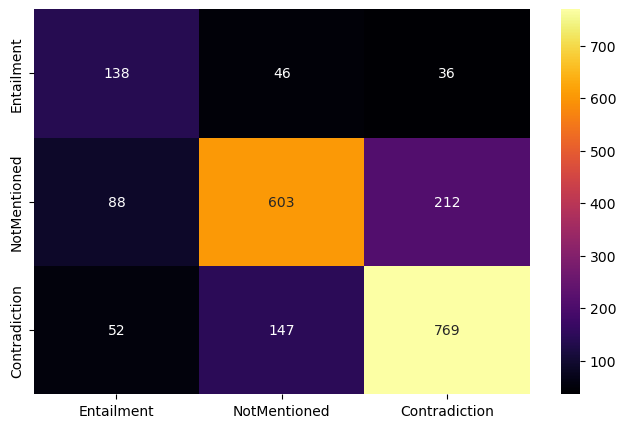

In [41]:
class_labels = mapping.keys()

cm = confusion_matrix(test_df['label'], test_preds3)

plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='inferno', xticklabels=class_labels, yticklabels=class_labels)

plt.xticks(np.arange(len(class_labels)) + 0.5, class_labels)
plt.yticks(np.arange(len(class_labels)) + 0.5, class_labels)
plt.show()

<a ><font size="3"><b>OBSERVATION:</b></font></a>

- It appears that the 'roberta-base' model performs similarly to the previous 'microsoft/deberta-base' model.


---
# MODEL4: RoBERTa-base with processed text
---

## Define the model and tokenizer

In [42]:
model_name = 'roberta-base'

tokenizer4 = AutoTokenizer.from_pretrained(model_name)
model4 = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should pr

In [44]:
train_texts = train_df['processed_text'].tolist()
val_texts = val_df['processed_text'].tolist()
test_texts = test_df['processed_text'].tolist()

In [45]:
train_data = NliDataset(train_texts, train_hypotheses, train_labels, tokenizer4)
val_data = NliDataset(val_texts, val_hypotheses, val_labels,tokenizer4)
test_data = NliDataset(test_texts, test_hypotheses, test_labels,tokenizer4)

## Training 

In [46]:
trainer4 = Trainer(
    model=model4,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    tokenizer=tokenizer4,
    compute_metrics=compute_metrics,
#     optimizers=(optimizer, None),
)

In [47]:
TrainOutput4 = trainer4.train()
TrainOutput4 = pd.DataFrame([TrainOutput4.metrics])
TrainOutput4

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


train_runtime  train_samples_per_second  train_steps_per_second  \
0     1,506.6179                   14.3190                  0.8960   

                  total_flos  train_loss  epoch  
0 5,676,145,760,646,144.0000      0.7063 3.0000

## Evaluation

In [48]:
val_metrics4 = trainer4.evaluate(eval_dataset=val_data)
val_metrics4

{'eval_loss': 0.9512536525726318,
 'eval_Accuracy': 0.5969141755062681,
 'eval_Precision_Contradiction': 0.475,
 'eval_Precision_NotMentioned': 0.5699208443271768,
 'eval_Precision_Entailment': 0.6566265060240963,
 'eval_Recall_Contradiction': 0.5507246376811594,
 'eval_Recall_NotMentioned': 0.5242718446601942,
 'eval_Recall_Entailment': 0.6714579055441479,
 'eval_F1_score_Contradiction': 0.5100671140939598,
 'eval_F1_score_NotMentioned': 0.5461441213653604,
 'eval_F1_score_Entailment': 0.6639593908629441,
 'eval_macro_f1_score': 0.5733902087740881,
 'eval_runtime': 29.1929,
 'eval_samples_per_second': 35.522,
 'eval_steps_per_second': 2.227,
 'epoch': 3.0}

## Testing

In [49]:
test_predictions = trainer4.predict(test_data)
test_preds4 = np.argmax(test_predictions.predictions, axis=1)
test_metrics4 = trainer4.evaluate(eval_dataset=test_data)
test_metrics4

{'eval_loss': 0.9003843665122986,
 'eval_Accuracy': 0.6274509803921569,
 'eval_Precision_Contradiction': 0.49514563106796117,
 'eval_Precision_NotMentioned': 0.6002728512960437,
 'eval_Precision_Entailment': 0.6854146806482364,
 'eval_Recall_Contradiction': 0.5953307392996109,
 'eval_Recall_NotMentioned': 0.55,
 'eval_Recall_Entailment': 0.695357833655706,
 'eval_F1_score_Contradiction': 0.5406360424028269,
 'eval_F1_score_NotMentioned': 0.574037834311807,
 'eval_F1_score_Entailment': 0.6903504560729717,
 'eval_macro_f1_score': 0.6016747775958686,
 'eval_runtime': 57.806,
 'eval_samples_per_second': 36.173,
 'eval_steps_per_second': 2.266,
 'epoch': 3.0}

In [50]:
from sklearn.metrics import classification_report

report = classification_report(test_df['label'], test_preds4)
print(report)

              precision    recall  f1-score   support

           0       0.50      0.70      0.58       220
           1       0.80      0.65      0.71       903
           2       0.75      0.81      0.78       968

    accuracy                           0.73      2091
   macro avg       0.68      0.72      0.69      2091
weighted avg       0.74      0.73      0.73      2091



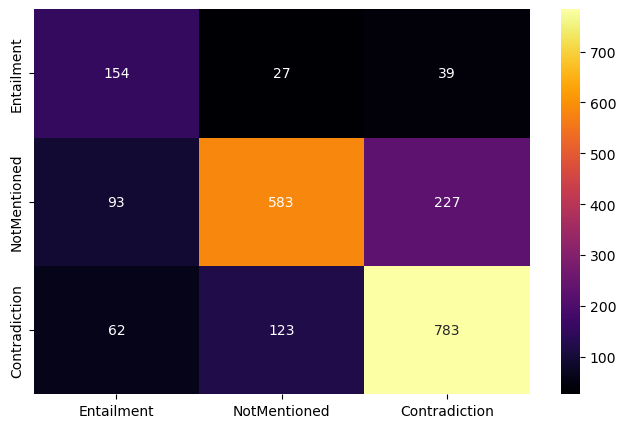

In [51]:
class_labels = mapping.keys()

cm = confusion_matrix(test_df['label'], test_preds4)

plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='inferno', xticklabels=class_labels, yticklabels=class_labels)

# Add labels, title, and axis ticks
plt.xticks(np.arange(len(class_labels)) + 0.5, class_labels)
plt.yticks(np.arange(len(class_labels)) + 0.5, class_labels)

# Display the heatmap
plt.show()

<a ><font size="3"><b>OBSERVATION:</b></font></a>
- Similar to the previous models, overfitting might be a concern due to the increasing validation loss.

## Saving Results 

In [42]:
for i, TrainOutput in enumerate([TrainOutput1, TrainOutput2, TrainOutput3, TrainOutput4]):
    
    with open(f'TrainOutput{i+1}.json', 'w') as json_file:
        json.dump(TrainOutput, json_file)
        
for i, test_metrics in enumerate([test_metrics1, test_metrics2, test_metrics3, test_metrics4]):
    
    with open(f'test_metrics{i+1}.json', 'w') as json_file:
        json.dump(test_metrics, json_file)
        
for i, val_metrics in enumerate([val_metrics1, val_metrics2, val_metrics3, val_metrics4]):
    
    with open(f'val_metrics{i+1}.json', 'w') as json_file:
        json.dump(val_metrics, json_file)
        
for i, cm in enumerate([cm1, cm2, cm3, cm4]):
    
    with open(f'cm{i+1}.json', 'w') as json_file:
        json.dump(cm.tolist(), json_file)

### Load Saved files

In [43]:
TrainOutputs = []
for i in range(1, 5):
    with open(f'TrainOutput{i}.json', 'r') as json_file:
        TrainOutput = json.load(json_file)
        TrainOutputs.append(TrainOutput)

# Reading test_metrics JSON files
test_metrics_list = []
for i in range(1, 5):
    with open(f'test_metrics{i}.json', 'r') as json_file:
        test_metrics = json.load(json_file)
        test_metrics_list.append(test_metrics)

# Reading val_metrics JSON files
val_metrics_list = []
for i in range(1, 5):
    with open(f'val_metrics{i}.json', 'r') as json_file:
        val_metrics = json.load(json_file)
        val_metrics_list.append(val_metrics)

# Reading confusion matrices JSON files
cms = []
for i in range(1, 5):
    with open(f'cm{i}.json', 'r') as json_file:
        cm = json.load(json_file)
        cms.append(cm)

In [334]:
TrainOutputs

[{'Epoch': [1, 2, 3],
  'Training Loss': [0.6812, 0.6351, 0.581],
  'Validation Loss': [0.81239, 0.93501, 1.09217],
  'Accuracy': [0.606557, 0.611379, 0.583414],
  'Precision Contradiction': [0.598291, 0.591304, 0.528846],
  'Precision Notmentioned': [0.550495, 0.601881, 0.530474],
  'Precision Entailment': [0.677108, 0.620232, 0.642857],
  'Recall Contradiction': [0.507246, 0.492754, 0.398551],
  'Recall Notmentioned': [0.674757, 0.466019, 0.570388],
  'Recall Entailment': [0.577002, 0.767967, 0.646817],
  'F1 Score Contradiction': [0.54902, 0.537549, 0.454545],
  'F1 Score Notmentioned': [0.606325, 0.525308, 0.549708],
  'F1 Score Entailment': [0.62306, 0.686239, 0.644831],
  'Macro F1 Score': [0.592801, 0.583032, 0.549695],
  'train_runtime': [0, 2.3171641, 0],
  'train_samples_per_second': [0, 9.31, 0],
  'train_steps_per_second': [0, 0.583, 0],
  'total_flos': [0, 6614280971596800.0, 0],
  'train_loss': [0.654, 0, 0],
  'epoch': [3.0, 0, 0]},
 {'Epoch': [1, 2, 3],
  'Training Loss

---
# ERROR ANALYSIS
---

### Error Analysis with Training and validation Metrics over epochs

In [275]:
def plot_metrics_over_epochs(metrics_dict, metrics_list):
    epochs = list(range(1, EPOCHS + 1))
    models = ['DeBERTa with processed text', 'DeBERTa with original text', 'RoBERTa with original text', 'RoBERTa with processed text']

    num_metrics = len(metrics_list)
    fig, axes = plt.subplots(num_metrics, 1, figsize=(8, 4*num_metrics), sharex=True)
    
    for i, metric_name in enumerate(metrics_list):
        for j, model_name in enumerate(models):
            axes[i].plot(epochs, metrics_dict[j][metric_name], label=f'{model_name}')
        axes[i].set_ylabel(metric_name)
        axes[i].set_title(f'Models over - {metric_name}')
        axes[i].legend(fontsize = 9)
        axes[i].grid(True)
    
    plt.xlabel('Epochs')
    plt.xticks(epochs)
    plt.tight_layout()
    plt.show()


**Plot training and validation set**

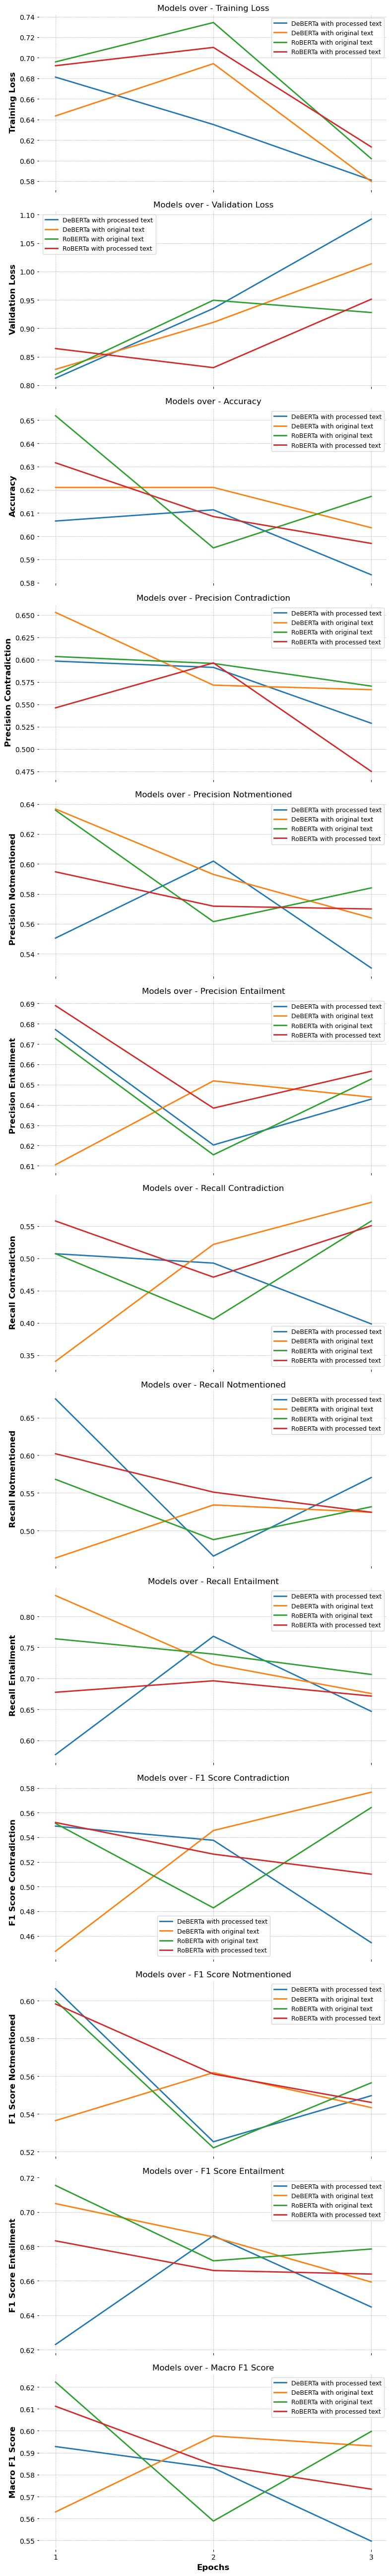

In [277]:
metrics_list = ['Training Loss', 'Validation Loss', 'Accuracy','Precision Contradiction',
                'Precision Notmentioned', 'Precision Entailment', 'Recall Contradiction', 
                'Recall Notmentioned', 'Recall Entailment', 'F1 Score Contradiction', 
                'F1 Score Notmentioned', 'F1 Score Entailment', 'Macro F1 Score']

plot_metrics_over_epochs(TrainOutputs, metrics_list)

**Plot testing set**

In [327]:

def plot_metrics(metrics_dict_list):
    metrics_list = ['eval_loss', 'eval_Accuracy', 'eval_Precision_Contradiction', 
                    'eval_Precision_NotMentioned', 'eval_Precision_Entailment', 
                    'eval_Recall_Contradiction', 'eval_Recall_NotMentioned', 'eval_Recall_Entailment', 
                    'eval_F1_score_Contradiction', 'eval_F1_score_NotMentioned', 'eval_F1_score_Entailment', 'eval_macro_f1_score']
    model_names = ['DeBERTa with processed text', 'DeBERTa with original text', 'RoBERTa with original text', 'RoBERTa with processed text'] 
    
    num_models = len(metrics_dict_list)
    num_metrics = len(metrics_list)
    
    fig, axes = plt.subplots(num_metrics, 1, figsize=(9, 4*num_metrics), sharex=True)

    for i, metric_name in enumerate(metrics_list):
        metric_values = [metrics_dict[metric_name] for metrics_dict in metrics_dict_list]
        bars = axes[i].bar(model_names, metric_values, color=pastel_colors)
        axes[i].set_ylabel(metric_name)
        axes[i].set_title(f'Models over - {metric_name}')
        axes[i].grid(True)

        # Add legend for each bar group (model) to the right of the subplot
        axes[i].legend(bars, model_names, loc='upper right')

    plt.xlabel('Models')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

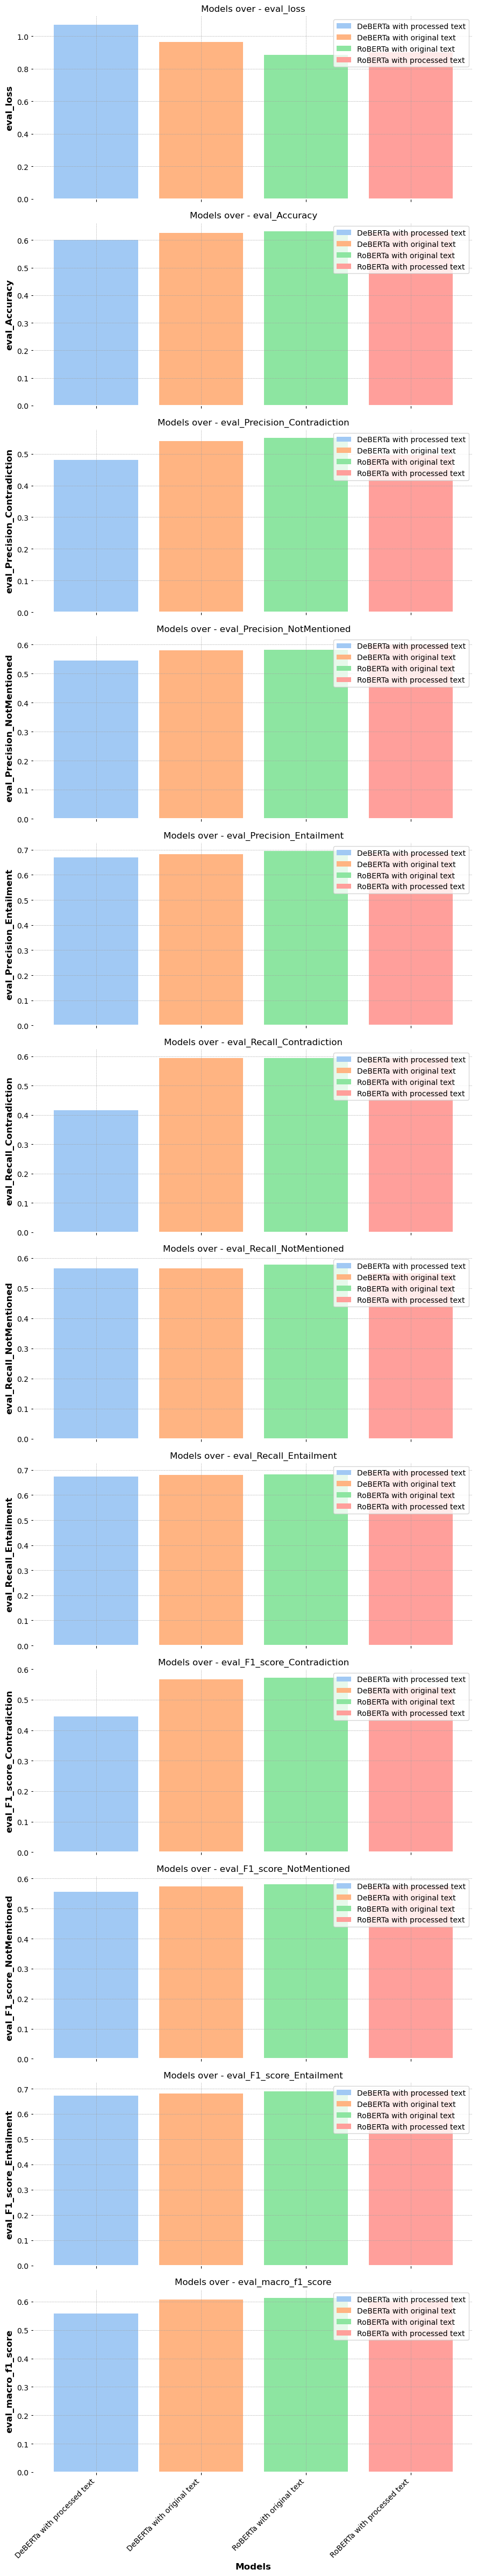

In [328]:
plot_metrics(test_metrics_list)

### Error Analysis with Confusion Matrix

In [261]:
import seaborn as sns

def plot_confusion_matrices(cms):
    
    models = ['DeBERTa with processed text', 'DeBERTa with original text', 'RoBERTa with original text', 'RoBERTa with processed text']
    fig, axes = plt.subplots(1, len(cms), figsize=(25, 5))
    
    for i, cm in enumerate(cms):
        ax = sns.heatmap(cm, annot=True, fmt='d', cmap='inferno', ax=axes[i])
        ax.set_title(f'{models[i]}')
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')

    plt.tight_layout()
    plt.show()

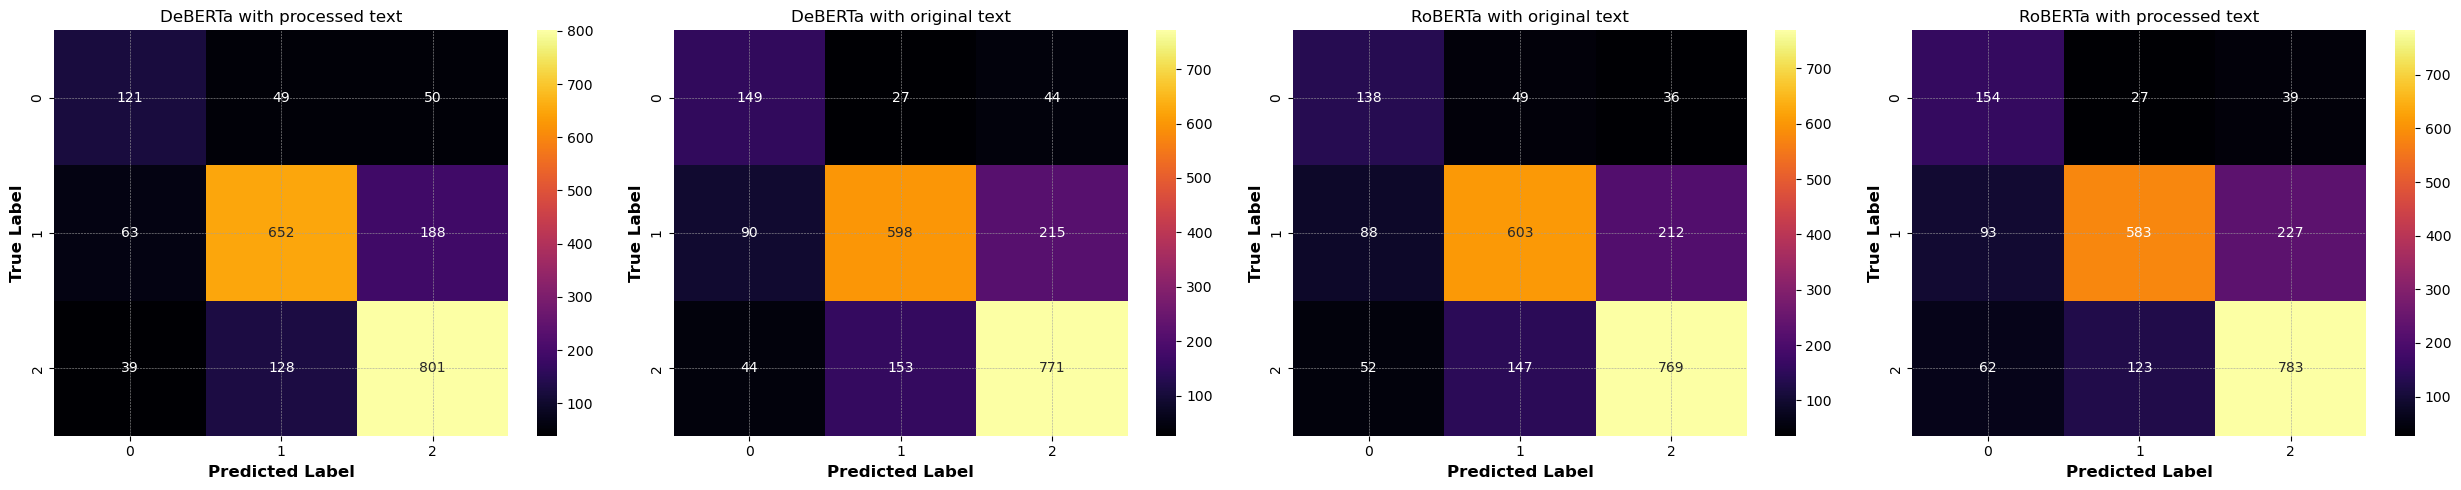

In [262]:
plot_confusion_matrices(cms)

---
## Comparasion

- **Training Loss and Validation Loss:** The training loss consistently decreases with each epoch, indicating that the model is learning from the training data. However, the validation loss slightly increases after the second epoch, suggesting that the model might be overfitting to the training data after that point.

- **Accuracy:** The accuracy of the model on the validation data fluctuates between epochs, with no clear trend of improvement or degradation. The model seems to perform similarly on the validation data across epochs.

- **Precision, Recall, and F1 Score:** The precision, recall, and F1 scores for the different classes ("Contradiction," "Not Mentioned," and "Entailment") also vary across epochs.

- All four models perform similarly with accuracies around 73% and macro F1 scores around 0.69 to 0.70.
- The models trained with and without text cleaning exhibit comparable performances, indicating that text cleaning did not significantly impact the results in this case.
- The 'deberta-base' model seems to have slightly higher accuracy and macro F1 score than the 'roberta-base' model. However, the differences are relatively small.

> Overall, it is essential to analyze the trends of these metrics to determine if the model is learning effectively and generalizing well to the validation data. Additionally, it may be necessary to perform further analysis, such as comparing the performance of different models, adjusting hyperparameters, or conducting more epochs, to optimize the model's performance.


---
# IMPROVEMENTS APPROCHES
---

- **Hyperparameter Tuning**: Optimize the hyperparameters of the model, such as learning rate, batch size, dropout rate, and the number of hidden layers. Hyperparameter tuning can significantly impact the model's performance.

- **Model Architecture:** Experiment with different model architectures or pre-trained models. You can try using larger models or models with different attention mechanisms to capture more complex patterns in the data.

- **Ensemble Methods:** Combine predictions from multiple models using ensemble methods. Ensemble models can often lead to improved performance by leveraging the strengths of individual models.

- **Regularization:** Apply regularization techniques such as L1 and L2 regularization to prevent overfitting and improve model generalization.

- **Learning Rate Scheduling:** Implement learning rate scheduling to adjust the learning rate during training dynamically. It can help the model converge faster and achieve better performance.

- **Loss Function:** Use weighted loss functions to give more importance to the minority class.